# import

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib
import warnings
import sklearn
import scipy
import numpy
import json
import sys
import csv
import os
import re

from rdkit.Chem import MolFromSmiles
from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import MolToSmiles

pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')
sns.set(color_codes=True)
plt.style.available
%matplotlib inline
%precision 2

from utils import split_train_line, split_test_line

# Read data

In [3]:
with open('../input/training/train.txt', 'r') as f:
    train_lines = f.readlines()
del train_lines[0]
len(train_lines)

20813

In [4]:
with open('../input/training/test.txt', 'r') as f:
    test_lines = f.readlines()
del test_lines[0]
len(test_lines)

5188

In [5]:
train_reactions = []
for line in train_lines:
    train_reactions.append(split_train_line(line))
train = pd.DataFrame(train_reactions)

train.shape

(20813, 5)

In [6]:
train.head()

,id,production,reactant,reagent,xxx
0,00000,[O=C(O)CCCCCCC1=C(C=Cc2ccccc2)C(O)CC1=O],"[O=C(O)C(=O)O, [OH-], O, [K+], O=C(O)CCCCCCCC(...",[ClC(Cl)Cl],"|f:0.1,3.4.5|"
1,00001,[O=C1NCCN1C(c1ccccc1)c1ccccc1],"[O=C([O-])[O-], O=C1NCCN1, ClC(c1ccccc1)c1cccc...",[CS(C)=O],|f:1.2.3|
2,00002,[O=C(NCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccccc1],"[O=C(c1ccccc1)N1CC1, OC1(c2ccc(Cl)cc2)CCNCC1, ...",[CCOCC],
3,00003,[CN(C)CC1CCN2c3ccccc3Cc3ccccc3C2C1],"[COC=O, O=C(O)/C=C/C(=O)O, CN(C)CC1CCN2c3ccccc...","[CO, CC(C)=O]","|f:1.2,3.4|"
4,00004,"[[Cl-], C[N+](C)(CCCN)CC(=O)Nc1ccc([N+](=O)[O-...","[[Na+], C[N+](C)(CCCNC=O)CC(=O)Nc1ccc([N+](=O)...",[O],"|f:0.1,3.4,6.7|"


In [7]:
test_reaction = []
for line in test_lines:
    test_reaction.append(split_test_line(line))
test = pd.DataFrame(test_reaction)
# test.head()
test.shape

(5188, 4)

# Molecular number dist of train/test

In [8]:
train['train_reactant_mol_num'] = train['reactant'].map(lambda x: len(x))
train['train_reagent_mol_num'] = train['reagent'].map(lambda x: len(x))
train['train_production_mol_num'] = train['production'].map(lambda x: len(x))
test['test_reagent_mol_num'] = test['reagent'].map(lambda x: len(x))
test['test_production_mol_num'] = test['production'].map(lambda x: len(x)) # if type(x) == list else 1)

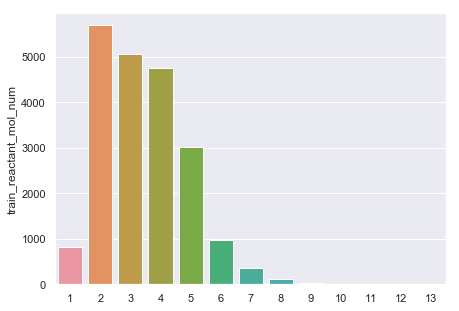

In [9]:
plt.figure(figsize=(7, 5))
train_reactant_len_dist = train['train_reactant_mol_num'].value_counts()
sns.barplot(train_reactant_len_dist.index, train_reactant_len_dist)

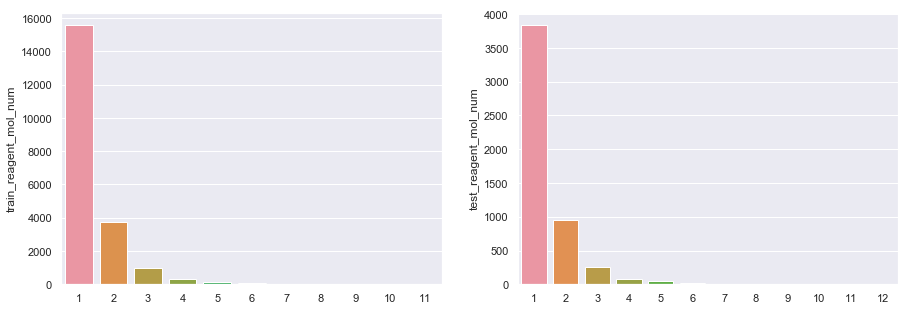

In [10]:
plt.figure(figsize=(15, 5))
train_reactant_len_dist = train['train_reagent_mol_num'].value_counts()
test_reactant_len_dist = test['test_reagent_mol_num'].value_counts()
plt.subplot(121)
sns.barplot(train_reactant_len_dist.index, train_reactant_len_dist)
plt.subplot(122)
sns.barplot(test_reactant_len_dist.index, test_reactant_len_dist)

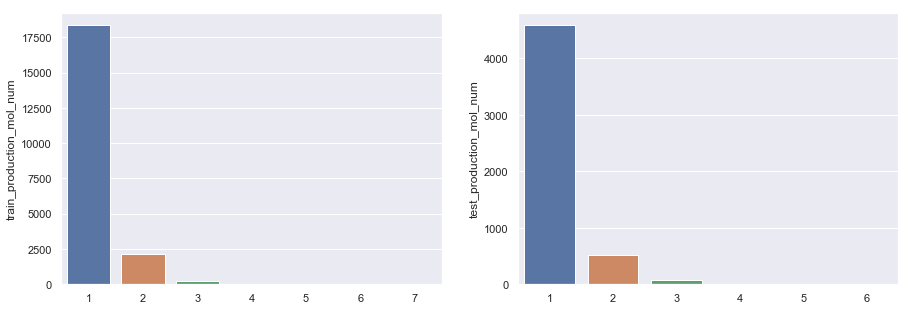

In [11]:
plt.figure(figsize=(15, 5))
train_production_len_dist = train['train_production_mol_num'].value_counts()
test_production_len_dist = test['test_production_mol_num'].value_counts()
plt.subplot(121)
sns.barplot(train_production_len_dist.index, train_production_len_dist)
plt.subplot(122)
sns.barplot(test_production_len_dist.index, test_production_len_dist)

# Molecular reactant dist of train

In [12]:
train['reactant'].shape

(20813,)

In [17]:
# train reactants dist
train_reactants_dic = {}
for reactants in train['reactant']:   # type: list
    for reactant in reactants:
        if reactant in train_reactants_dic:
            train_reactants_dic[reactant] += 1
        else:
            train_reactants_dic[reactant] = 1
# train_reactants = sorted(train_reactants_dic.items(),key = lambda x:x[1],reverse = True)

train_reactants = pd.DataFrame({
    'mol': list(train_reactants_dic.keys()),
    'number': list(train_reactants_dic.values()),
})

def atom_number_of_mol(smi):
    mol = MolFromSmiles(smi)
    if mol is not None:
        return mol.GetNumAtoms()
    else:
        return 0

train_reactants['mol_atom_n'] = train_reactants['mol'].map(lambda x: atom_number_of_mol(x)) 

train_reactants.head()

plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_reactants, kind="kde", space=0, color="g")

### 将x轴限制在(0,2000)

<Figure size 1080x1080 with 0 Axes>

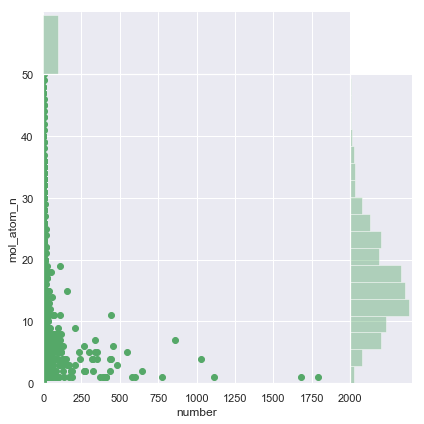

In [22]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_reactants, space=0, color="g", xlim=(0,2000), ylim=(0, 50))

#### 从上图看出，在两个方向上都有outlies

In [23]:
### 将x轴限制在(0,1000)

<Figure size 1080x1080 with 0 Axes>

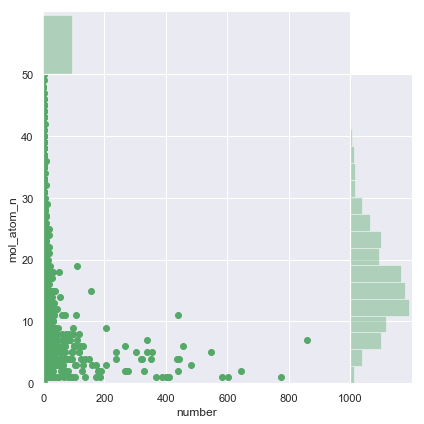

In [21]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_reactants, space=0, color="g", xlim=(0,1000), ylim=(0, 50))

# Molecular reagents dist of train

In [29]:
# train reagents dist
train_reagents_dic = {}
for reagents in train['reagent']:   # type: list
    for reagent in reagents:
        if reagent in train_reagents_dic:
            train_reagents_dic[reagent] += 1
        else:
            train_reagents_dic[reagent] = 1
# train_reagents = sorted(train_reagents_dic.items(),key = lambda x:x[1],reverse = True)

train_reagents = pd.DataFrame({
    'mol': list(train_reagents_dic.keys()),
    'number': list(train_reagents_dic.values()),
})

def atom_number_of_mol(smi):
    mol = MolFromSmiles(smi)
    if mol is not None:
        return mol.GetNumAtoms()
    else:
        return 0

train_reagents['mol_atom_n'] = train_reagents['mol'].map(lambda x: atom_number_of_mol(x)) 

train_reagents.head()

,mol,number,mol_atom_n
0,ClC(Cl)Cl,677,4
1,CS(C)=O,265,4
2,CCOCC,1436,5
3,CO,1830,2
4,CC(C)=O,628,4


<Figure size 1080x1080 with 0 Axes>

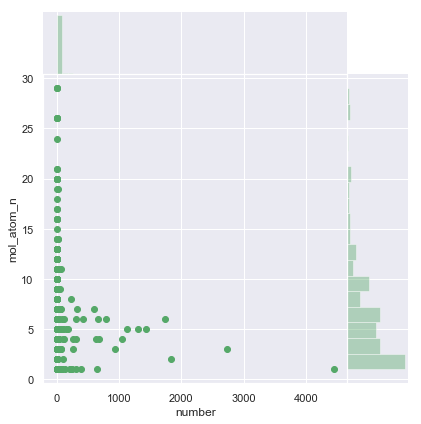

In [30]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_reagents, space=0, color="g")

<Figure size 1080x1080 with 0 Axes>

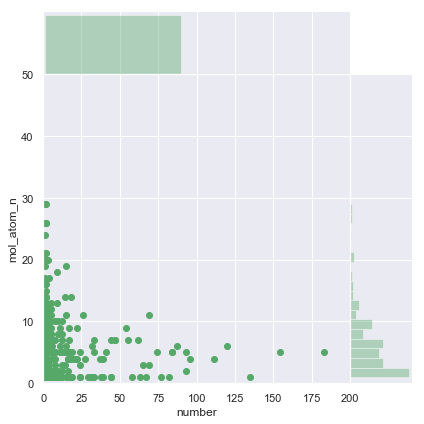

In [31]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_reagents, space=0, color="g", xlim=(0,200), ylim=(0, 50))

# Molecular product dist of train

In [24]:
# train productions dist
train_productions_dic = {}
for productions in train['production']:   # type: list
    for production in productions:
        if production in train_productions_dic:
            train_productions_dic[production] += 1
        else:
            train_productions_dic[production] = 1
# train_productions = sorted(train_productions_dic.items(),key = lambda x:x[1],reverse = True)

train_productions = pd.DataFrame({
    'mol': list(train_productions_dic.keys()),
    'number': list(train_productions_dic.values()),
})

def atom_number_of_mol(smi):
    mol = MolFromSmiles(smi)
    if mol is not None:
        return mol.GetNumAtoms()
    else:
        return 0

train_productions['mol_atom_n'] = train_productions['mol'].map(lambda x: atom_number_of_mol(x)) 

train_productions.head()

,mol,number,mol_atom_n
0,O=C(O)CCCCCCC1=C(C=Cc2ccccc2)C(O)CC1=O,1,24
1,O=C1NCCN1C(c1ccccc1)c1ccccc1,1,19
2,O=C(NCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccccc1,1,25
3,CN(C)CC1CCN2c3ccccc3Cc3ccccc3C2C1,1,23
4,[Cl-],118,1


<Figure size 1080x1080 with 0 Axes>

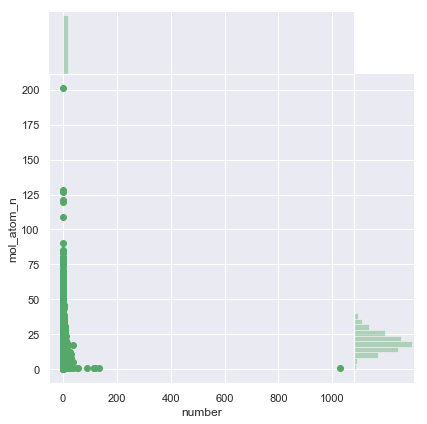

In [28]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_productions, space=0, color="g")

<Figure size 1080x1080 with 0 Axes>

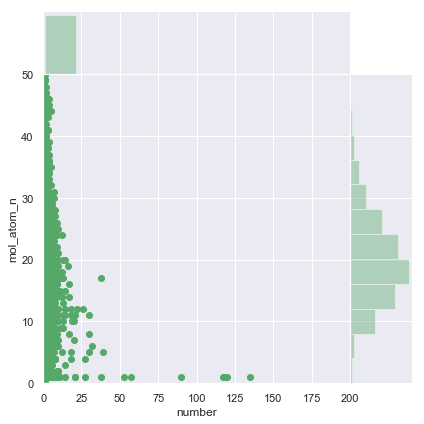

In [27]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_productions, space=0, color="g", xlim=(0,200), ylim=(0, 50))

In [ ]:
plt.figure(figsize=(15, 15))
sns.jointplot("number", "mol_atom_n", data=train_reactants, kind="kde", space=0, color="g", xlim=(0,1000), ylim=(0, 50))

#### 从上图看出，number主要在(0, 50), mol_atom_n主要在(0, 200)

###  统计原子数》100的分子，并打印出来

In [19]:
mol_atom_n_greater_100 = []
for key, value in train_reactants:
    mol = MolFromSmiles(key)
    if mol is not None:
        atom_num = mol.GetNumAtoms()
        if atom_num >= 100:
            mol_atom_n_greater_100.append(key)

ValueError: too many values to unpack (expected 2)

In [ ]:
mol_atom_n_greater_100

In [ ]:
for mol in mol_atom_n_greater_100:
    MolFromSmiles(mol)

In [ ]:

# atom_dic={}
# for i in range(1112657):
#     sour = f['reactantsmi'][i] 
#     a=sour.split('.')
#     for j in range(len(a)):
#         smi = MolFromSmiles(a[j])
#         if smi!=None:
#             atom_num=smi.GetNumAtoms()
            
#         if atom_num in atom_dic:
#             atom_dic[atom_num]+=1
#         else:
#             atom_dic[atom_num]=1

# Features

## Statistical Count Features
- 1 Word Count - Total number of words in the headline
- 2 Character Count - Total number of characters in the headline excluding spaces
- 3 Word Density - Average length of the words used in the headline
- 4 Punctuation Count - Total number of punctuations used in the headline
- 5 Upper-Case to Lower-Case Words ratio - ratio of upper case words used and lower case words used in the text